In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from itertools import product
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Import data


In [56]:
f='../data/'
test          = pd.read_csv(f+'test.csv.gz')
shop          = pd.read_csv(f+'shops.csv')
submission    = pd.read_csv(f+'sample_submission.csv.gz')
sales         = pd.read_csv(f+'sales_train.csv.gz')
items         = pd.read_csv(f+'items.csv')
item_category = pd.read_csv(f+'item_categories.csv')

# Aggregate data
Since the test data is generated with combination of shops and items, we have to restructure train data to match the test data generation. 

In [57]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

#Compute all shops/items combinations
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
print(grid)

          shop_id  item_id  date_block_num
0              59    22154               0
1              59     2552               0
2              59     2554               0
3              59     2555               0
4              59     2564               0
5              59     2565               0
6              59     2572               0
7              59     2573               0
8              59     2574               0
9              59     2593               0
10             59     2604               0
11             59     2607               0
12             59     2609               0
13             59     2548               0
14             59     2611               0
15             59     2546               0
16             59     2515               0
17             59     2705               0
18             59     2715               0
19             59     2716               0
20             59     2719               0
21             59     2720               0
22         

# Exploratory Data Analysis

There is 60 unique shop_id

In [58]:
shop.head(5)
shop.describe()
shop.shop_id.unique()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64)

There is 60 unique item_category_id.

In [59]:
item_category.head(5)
item_category.describe()
item_category.item_category_id.unique()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
      dtype=int64)

There is 22170 unique item_id.

In [60]:
items.loc[42].item_name

'100 Best romantic melodies (mp3-CD) (Digipack)'

In [61]:
items.head(5)
items.describe()
items.item_id.unique().shape[0]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


22170

Review the format for submission.

In [62]:
test.head(5)
submission.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


Finally, the main dataset for training data. 

In [63]:
sales.head(5)
sales.describe()
len(sales)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


2935849

# Plot of date_block_num against index. 

The distribution of each date_block_num is balanced. 

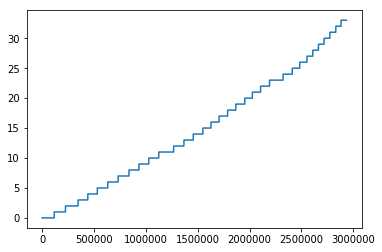

In [64]:
sales.date_block_num.plot()

# Shops Leakage utilization

Shops geography aren't anonimized, so we can substact some information from the feature names

In [65]:
#This addresses are seems to be the same
for i in [10,11]:
    print(shop.loc[i].shop_name)
print('-'*20)
shop.at[10,'shop_name']=shop.loc[11,'shop_name']

#Remove ! sign from city name
shop.shop_name = shop.shop_name.apply(lambda x: x.replace('!',''))
   

# Group to e-shops into single category
print(shop.loc[55].shop_name)
print(shop.loc[12].shop_name)
shop.at[55,'shop_name']='Интернет-магазин '+shop.at[55,'shop_name']

display(shop)


Жуковский ул. Чкалова 39м?
Жуковский ул. Чкалова 39м²
--------------------
Цифровой склад 1С-Онлайн
Интернет-магазин ЧС


,shop_name,shop_id
0,"Якутск Орджоникидзе, 56 фран",0
1,"Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


Cut city name from the shop name, also normalize city name. Thanks God I'm Russian and can identify Russian cities by their acronyms :)

In [66]:
from sklearn.preprocessing import LabelEncoder
shop['shop_city'] = shop['shop_name'].str.split().str[0].str.strip()

# Parse results of city parser, normalize city names
replace_table=[
     ['РостовНаДону', 'Ростов-на-Дону',]
    ,['СПб'         , 'Санкт-Петербург']
    ,['Адыгея'      , 'Краснодар'      ] # Адыгея ТЦ "Мега" locates in Krasnodar City
    ,['Н.Новгород'  , 'Нижний Новгород']
    ,['Сергиев'     , 'Сергиев Посад'  ] # Two word city name wasn't parsed in a correct way
]
for w in replace_table:
    shop.shop_city = shop.shop_city.apply(lambda x: x.replace(w[0],w[1]))
    
shop['shop_city_id'] = LabelEncoder().fit_transform(shop['shop_city'])
display(shop)


,shop_name,shop_id,shop_city,shop_city_id
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,28
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,28
2,"Адыгея ТЦ ""Мега""",2,Краснодар,10
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,2
6,"Воронеж (Плехановская, 13)",6,Воронеж,3
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,3
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,3
9,Выездная Торговля,9,Выездная,4


In [67]:
print('Unique shops  %2d'%len(shop.shop_name.unique()))
print('Unique cities %2d'%len(shop.shop_city.unique()))


Unique shops  59
Unique cities 30


Download Russian Cities database in JSON https://github.com/pensnarik/russian-cities 

In [68]:
ru_cities = pd.read_json('../russian-cities.json',encoding='utf-8')
display(ru_cities.head(10))
city2pop  = dict(zip(ru_cities.name, ru_cities.population))
city2subj = dict(zip(ru_cities.name, ru_cities.subject))


,coords,district,name,population,subject
0,"{'lat': '52.65', 'lon': '90.08333'}",Сибирский,Абаза,17111,Хакасия
1,"{'lat': '53.71667', 'lon': '91.41667'}",Сибирский,Абакан,186619,Хакасия
2,"{'lat': '53.68333', 'lon': '53.65'}",Приволжский,Абдулино,20663,Оренбургская область
3,"{'lat': '44.86667', 'lon': '38.16667'}",Южный,Абинск,34926,Краснодарский край
4,"{'lat': '55.9', 'lon': '53.93333'}",Приволжский,Агидель,16365,Башкортостан
5,"{'lat': '56.51667', 'lon': '52.98333'}",Приволжский,Агрыз,19299,Татарстан
6,"{'lat': '44.884525', 'lon': '39.19202'}",Южный,Адыгейск,12689,Адыгея
7,"{'lat': '54.85', 'lon': '53.06667'}",Приволжский,Азнакаево,34859,Татарстан
8,"{'lat': '47.1', 'lon': '39.41667'}",Южный,Азов,82882,Ростовская область
9,"{'lat': '51.16667', 'lon': '90.6'}",Сибирский,Ак-Довурак,13469,Тыва


In [69]:
shop['shop_city_pop' ] = shop['shop_city'].map(city2pop).fillna(-1).astype('int32')
shop['shop_city_subj'] = shop['shop_city'].map(city2subj).fillna('not-a-city')
shop['shop_city_subj_id'] = LabelEncoder().fit_transform(shop['shop_city_subj'])

display(shop)

,shop_name,shop_id,shop_city,shop_city_id,shop_city_pop,shop_city_subj,shop_city_subj_id
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,28,269486,Якутия,21
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,28,269486,Якутия,21
2,"Адыгея ТЦ ""Мега""",2,Краснодар,10,744933,Краснодарский край,6
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0,215353,Московская область,10
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1,314436,Волгоградская область,2
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,2,301642,Вологодская область,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,3,889680,Воронежская область,4
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,3,889680,Воронежская область,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,3,889680,Воронежская область,4
9,Выездная Торговля,9,Выездная,4,-1,not-a-city,0


Cool! So we generated new heuristic features from geography, which may be helpful for classifier
* Shop City
* Shop City population, no we can aggregate data for small cities and big one
* Shop City subject, which also may be usefull. 

# Explore Item Categories

In [70]:
pd.set_option("display.max_rows", 101)

# Create meta-categories, buy just splitting left word from category name

# As splitter use sign "(" or "-"

item_category['item_metacategory_name'] = item_category['item_category_name'].str.split('-|\\(').str[0].str.strip()
item_category['item_metacategory_id']   = LabelEncoder().fit_transform(item_category['item_metacategory_name'])

display(item_category)

print('Unique categories      %2d'%len(item_category.item_category_name.unique()))
print('Unique meta-categories %2d'%len(item_category.item_metacategory_name.unique()))


,item_category_name,item_category_id,item_metacategory_name,item_metacategory_id
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1
5,Аксессуары - PSVita,5,Аксессуары,1
6,Аксессуары - XBOX 360,6,Аксессуары,1
7,Аксессуары - XBOX ONE,7,Аксессуары,1
8,Билеты (Цифра),8,Билеты,2
9,Доставка товара,9,Доставка товара,3


Unique categories      84
Unique meta-categories 18


# Explore Item Names

Spoiler : this approach didn't bring any result.

In [71]:
items.sample(100)

,item_name,item_id,item_category_id
22126,Я ПЛЮЮ НА ВАШИ МОГИЛЫ 2,22126,40
15649,НЕВОЗМОЖНОЕ э (BD),15649,37
17254,ПОСЛЕ НАШЕЙ ЭРЫ (BD),17254,37
14066,ЛЮБОВЬ И ГОЛУБИ (регион),14066,40
7671,WINEHOUSE AMY Back To Black LP,7671,58
6329,STARR RINGO Ringo 2012,6329,55
17082,ПИРАТЫ ХХ ВЕКА (регион),17082,40
19457,Стивенсон Р.Л. Приключения принца Флоризеля (mp3-CD) (Jewel),19457,43
18218,СБ. Disco Дача,18218,55
1046,"3D КОЛЛЕКЦИЯ: Коралина в стране кошмаров / Паранорман, или как приручить зомби / Семейка монстро...",1046,41


From forum we know that naive TF_IDF features are not useful and it makes sense - here we have very specific set of strings.

We should use instead some more heuristic, prior-knowledge features.

Let's have a look, can make a features based on games name

In [72]:
games = ['Need for Speed Most Wanted',
        'Call of Duty: Advanced Warfare',
         'Warhammer 40000',
        'Grand Theft Auto IV']
for g in games:
    df  = items[items['item_name'].str.contains(g)]
    display(df)
    print('Found %d verisions of %s'%(len(df),g))

,item_name,item_id,item_category_id
5228,Need for Speed Most Wanted (Classics) (рус.в.) (PC-DVD) (Jewel),5228,30
5229,"Need for Speed Most Wanted (EA) [PC, Цифровая версия]",5229,31
5230,"Need for Speed Most Wanted [Android, Цифровая версия]",5230,26


Found 3 verisions of Need for Speed Most Wanted


,item_name,item_id,item_category_id
2282,"Call of Duty: Advanced Warfare [PC, Цифровая версия]",2282,31
2283,"Call of Duty: Advanced Warfare [PC, русская версия]",2283,30
2284,"Call of Duty: Advanced Warfare [PS3, русская версия]",2284,19
2285,"Call of Duty: Advanced Warfare [PS4, русская версия]",2285,20
2286,"Call of Duty: Advanced Warfare [Xbox 360, русская версия]",2286,23
2287,"Call of Duty: Advanced Warfare [Xbox One, русская версия]",2287,24
2288,"Call of Duty: Advanced Warfare. Atlas Limited Edition [PC, русская версия]",2288,28
2289,"Call of Duty: Advanced Warfare. Atlas Limited Edition [PS4, английская версия]",2289,20
2290,"Call of Duty: Advanced Warfare. Atlas Limited Edition [Xbox One, английская версия]",2290,24
2291,"Call of Duty: Advanced Warfare. Atlas Pro Edition [PS4, английская версия]",2291,20


Found 22 verisions of Call of Duty: Advanced Warfare


,item_name,item_id,item_category_id
7569,WARHAMMER 40000 ACCESSORIES: Warhammer 40000 Rulebook (ENGLISH) 7-ая редакция арт. 40-02-60,7569,64
7777,"Warhammer 40000 Dawn of War. Retribution [PC, Jewel]",7777,30
7778,Warhammer 40000 Dawn of War. Retribution. Космодесант [PC],7778,28
7779,Warhammer 40000. Dawn of War Soulstorm (PC-DVD) (Jewel),7779,30
13154,"Классика жанра. Warhammer 40000 Dawn of War. Retribution [PC, Jewel, русская версия]",13154,30
19296,Сборник Premium Games. Warhammer 40000. Dawn of War. Полное издание и дополнения (PC-DVD) (DVD-box),19296,30


Found 6 verisions of Warhammer 40000


,item_name,item_id,item_category_id
3713,"Grand Theft Auto IV (Classics) [Xbox 360, русская документация]",3713,23
3714,Grand Theft Auto IV (full eng) (PS3) (Case Set),3714,19
3715,"Grand Theft Auto IV (СофтКлаб) [PC, Цифровая версия]",3715,31
3716,"Grand Theft Auto IV Complete Edition [PS3, английская версия]",3716,19
3717,"Grand Theft Auto IV Complete Edition [Xbox 360, английская версия]",3717,23
3718,Grand Theft Auto IV DVD,3718,30
3719,"Grand Theft Auto IV. Полное издание [PC, Jewel, русские субтитры]",3719,30


Found 7 verisions of Grand Theft Auto IV


That looks interestring actually. Some games are presented in several categories, so we could make a vocabullary of game and identify if name of item contains this game name. Let's grag the names from Wikipedia

In [73]:
# Read list of games from Wikipedia

from wikitables import import_tables
import string
idx=list(string.ascii_uppercase)
idx.append('Numerical')
game_list=[]
for i in idx:
    if i=='A':
        page_name='List_of_PC_games'
    else:
        page_name='List_of_PC_games_(%s)'%i
    
    tables = import_tables(page_name) 
    if i=='Numerical':
        filed='Title'
    else:
        filed='Name'
        
    game_list+=[str(r[filed]) for r in tables[0].rows] 
print('Total games: %3d'%len(game_list))

List of PC games (R)[0][22]: dropping field from unknown column: Episode 1
List of PC games (R)[0][22]: dropping field from unknown column: Episode 2
List of PC games (R)[0][22]: dropping field from unknown column: Episode 3
List of PC games (R)[0][22]: dropping field from unknown column: Episode 4
List of PC games (R)[0][22]: dropping field from unknown column: 2015 02 24
List of PC games (R)[0][22]: dropping field from unknown column: 2015 03 03
List of PC games (R)[0][22]: dropping field from unknown column: 2015 03 10
List of PC games (R)[0][22]: dropping field from unknown column: 2015 03 17
List of PC games (R)[0][23]: missing field for column [Operating system(s)]
List of PC games (R)[0][23]: missing field for column [Date released]
List of PC games (R)[0][34]: dropping field from unknown column: +
List of PC games (R)[0][34]: dropping field from unknown column: Windows, Playstation 4
List of PC games (R)[0][34]: dropping field from unknown column: Xbox One
List of PC games (R)[

Total games: 862


In [74]:
all_games = pd.DataFrame(game_list,columns=['game_name'])
all_games.sample(20)

,game_name
686,The Sims 3: Island Paradise
605,Saints Row: The Third
363,Goat Simulator
80,Audiosurf
273,Dragon Age: Inquisition
512,Need for Speed: High Stakes
619,Silent Hunter 5: Battle of the Atlantic
456,Lego Star Wars: The Video Game
709,Tom Clancy's Splinter Cell: Chaos Theory
379,Grand Theft Auto: San Andreas


Let's have a look can we found our games in the list of downloaded games

In [75]:
games = ['Need for Speed Most Wanted',
        'Call of Duty: Advanced Warfare',
         'Warhammer 40000',
        'Grand Theft Auto IV']

for g in games:
    print(all_games[all_games['game_name'].str.contains(g)])

Empty DataFrame
Columns: [game_name]
Index: []
Empty DataFrame
Columns: [game_name]
Index: []
Empty DataFrame
Columns: [game_name]
Index: []
               game_name
377  Grand Theft Auto IV


But fast approach didn't lead to success, because games in tables are not normalized. We can think about tokenization of game names. I.e.
* Remove from names special signs
* Remove spaces
* Shorten names in vocabullary 
* Try to find shorten normalized names in items name



# Plot of shop_id against item_id on train and test data

Train data consists of sales/returns only, while test data was constructed as a cartesian product of all shops and items in the given month (shops * items) - so it will include a lot of "non-sales" occurrences

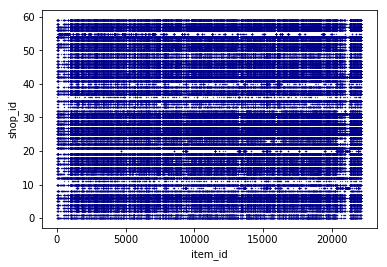

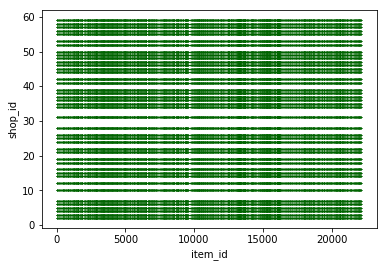

In [76]:
sales.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1)
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkGreen', s = 0.1)



We can see that after merging sales data on test data, there is about 50% of missing values.

In [77]:
test.merge(sales, how='left', on=['shop_id', 'item_id']).isnull().sum()

test.shape[0]

ID                     0
shop_id                0
item_id                0
date              102796
date_block_num    102796
item_price        102796
item_cnt_day      102796
dtype: int64

214200

Identify outliers in sales data. We found that there are some high price sales such as Radmin 3: Reliable Remote Support Software which more than USD 3468 or 200000 Russian Ruble.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


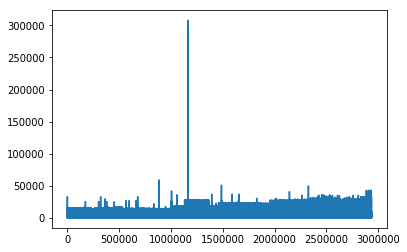

In [78]:
sales.item_price.plot()
sales[sales['item_price'] > 100000]
items[items['item_id'] == 6066]


For number of sales, there is an amount of sales more than 900. They are some kind of plastic bags and delivery services.

In [79]:
from IPython.display import display, HTML

# Assuming that dataframes df1 and df2 are already defined:
# print "Dataframe 1:"
# display(df1)
# print "Dataframe 2:"
# display(HTML(df2.to_html()))

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
845690,18.09.2013,8,42,3732,2521.211982,217.0
862929,17.09.2013,8,25,3732,2545.135417,264.0
890790,17.09.2013,8,31,3732,2550.597222,288.0
1058340,22.11.2013,10,12,11373,102.466942,242.0
1170072,28.12.2013,11,15,20949,5.000000,255.0
1501160,15.03.2014,14,24,20949,5.000000,405.0
1549966,09.04.2014,15,54,20949,5.000000,300.0
1573252,23.04.2014,15,27,8057,1200.000000,401.0
1573253,22.04.2014,15,27,8057,1200.000000,502.0
1618930,23.04.2014,15,29,8057,1200.000000,240.0


3732                             Grand Theft Auto V [PS3, русские субтитры]
3732                             Grand Theft Auto V [PS3, русские субтитры]
3732                             Grand Theft Auto V [PS3, русские субтитры]
11373                                  Доставка до пункта выдачи (Boxberry)
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
8057                                                       iTunes 1500 руб.
8057                                                       iTunes 1500 руб.
8057                                                       iTunes 1500 руб.
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
9242     Билет "ИгроМир 2014" (на один день (отдельно - 4, 5 октября 2014))
19437       

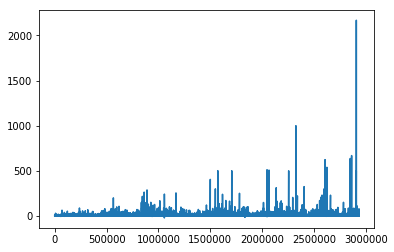

In [80]:
sales.item_cnt_day.plot()

popular_sales = sales[sales['item_cnt_day'] >200]
display(popular_sales)
pd.options.display.max_colwidth = 100
print(items.loc[popular_sales.item_id].item_name)

Outliers above are removed so we only include item price that less than 100000 and amount of sales that less or equal to 900.

In [81]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<=900]

# Aggregate data

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose.

In [82]:
sales.head(5)
sales_m = sales.groupby(['date_block_num','shop_id','item_id'])
display(sales_m.sum())
print('='*100)
display(sales)
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales_m = pd.merge(grid,sales_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

sales_m = pd.merge(sales_m,shop          ,on=['shop_id'],how='left')
sales_m = pd.merge(sales_m,items         ,on=['item_id'],how='left')
sales_m = pd.merge(sales_m,item_category , on=['item_category_id'], how='left')




,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


item_price  item_cnt_day
date_block_num shop_id item_id                          
0              0       32            884.0           6.0
                       33           1041.0           3.0
                       35            247.0           1.0
                       43            221.0           1.0
                       51            257.0           2.0
                       61            195.0           1.0
                       75             76.0           1.0
                       88             76.0           1.0
                       95            193.0           1.0
                       96             70.0           1.0
                       98           4288.0          25.0
                       111            89.0           1.0
                       149           297.0           3.0
                       151            75.0           1.0
                       153           258.0           1.0
                       198           112.0           1.0
                       210           236.0           2.0
                       282           109.0           1.0
                       306            59.0           1.0
                       351            89.0           1.0
                       421           162.0           1.0
                       438           162.0           1.0
                       482          2720.0           2.0
                       484           496.0           4.0
                       491           361.0           1.0
                       498           124.0           1.0
                       556           450.0           9.0
                       642           540.0           6.0
                       651           540.0           7.0
                       657           180.0           2.0
                       668            91.0           1.0
                       677           360.0           5.0
                       699           286.0           2.0
                       700          1144.0          11.0
                       715           273.0           3.0
                       783            71.0           1.0
                       810           480.0           4.0
                       835          1896.0           1.0
                       839          2720.0           2.0
                       944           339.0           1.0
                       947            74.0           2.0
                       952           321.0           1.0
                       963           216.0           7.0
                       965           190.0           1.0
                       987           154.0           2.0
                       989            58.0           1.0
                       990           232.0           4.0
                       992           116.0           2.0
                       993           116.0           2.0
                       996           116.0           2.0
...                                    ...           ...
33             59      18511         229.0           1.0
                       18595        2198.0           2.0
                       18924         169.0           1.0
                       19001         249.0           1.0
                       19046         349.0           1.0
                       19093         199.0           1.0
                       19144         399.0           1.0
                       19289         999.0           1.0
                       19291         999.0           1.0
                       19345         400.0           1.0
                       19406         399.0           1.0
                       19438        1799.0           1.0
                       19576         199.0           1.0
                       19588         399.0           1.0
                       19650         598.0           2.0
                       19655         598.0           4.0
                       19659         399.0           1.0
                       19672         399.0

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [83]:
display(sales_m)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,shop_name,shop_city,shop_city_id,shop_city_pop,shop_city_subj,shop_city_subj_id,item_name,item_category_id,item_category_name,item_metacategory_name,item_metacategory_id
0,59,22154,0,1.0,999.000000,"Ярославль ТЦ ""Альтаир""",Ярославль,29,591486,Ярославская область,22,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,10
1,59,2552,0,0.0,0.000000,"Ярославль ТЦ ""Альтаир""",Ярославль,29,591486,Ярославская область,22,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Музыка,12
2,59,2554,0,0.0,0.000000,"Ярославль ТЦ ""Альтаир""",Ярославль,29,591486,Ярославская область,22,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,Музыка,12
3,59,2555,0,0.0,0.000000,"Ярославль ТЦ ""Альтаир""",Ярославль,29,591486,Ярославская область,22,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,Музыка,12
4,59,2564,0,0.0,0.000000,"Ярославль ТЦ ""Альтаир""",Ярославль,29,591486,Ярославская область,22,DEEP PURPLE Perihelion: Live In Concert DVD (Кир.),59,Музыка - Музыкальное видео,Музыка,12
5,59,2565,0,0.0,0.000000,"Ярославль ТЦ ""Альтаир""",Ярославль,29,591486,Ярославская область,22,DEEP PURPLE Stormbringer (фирм.),56,Музыка - CD фирменного производства,Музыка,12
6,59,2572,0,0.0,0.000000,"Ярославль ТЦ ""Альтаир""",Ярославль,29,591486,Ярославская область,22,DEFTONES Koi No Yokan,55,Музыка - CD локального производства,Музыка,12
7,59,2573,0,0.0,0.000000,"Ярославль ТЦ ""Альтаир""",Ярославль,29,591486,Ярославская область,22,DEL REY LANA Born To Die,55,Музыка - CD локального производства,Музыка,12
8,59,2574,0,2.0,399.000000,"Ярославль ТЦ ""Альтаир""",Ярославль,29,591486,Ярославская область,22,DEL REY LANA Born To Die The Paradise Edition 2CD,55,Музыка - CD локального производства,Музыка,12
9,59,2593,0,0.0,0.000000,"Ярославль ТЦ ""Альтаир""",Ярославль,29,591486,Ярославская область,22,DEPECHE MODE Music For The Masses,55,Музыка - CD локального производства,Музыка,12


In [84]:

string_columns =['item_name','item_category_name','item_metacategory_name','shop_name','shop_city','shop_city_subj']
sales_m = sales_m.drop(columns=string_columns);
sales_m.item_price = sales_m.item_price.astype('int16');


In [86]:

display(sales_m)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id
0,59,22154,0,1.0,999,29,591486,22,37,10
1,59,2552,0,0.0,0,29,591486,22,58,12
2,59,2554,0,0.0,0,29,591486,22,58,12
3,59,2555,0,0.0,0,29,591486,22,56,12
4,59,2564,0,0.0,0,29,591486,22,59,12
5,59,2565,0,0.0,0,29,591486,22,56,12
6,59,2572,0,0.0,0,29,591486,22,55,12
7,59,2573,0,0.0,0,29,591486,22,55,12
8,59,2574,0,2.0,399,29,591486,22,55,12
9,59,2593,0,0.0,0,29,591486,22,55,12


# Mean encoding

We perform mean encoding on all category data which are item_id, shop_id and item_category_id

In [87]:
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id, agg_func, func_name in [ ('item_price',np.mean,'avg'),
                                           ('item_cnt_day',np.sum,'sum'),
                                           ('item_cnt_day',np.mean,'avg')]:

        mean_df = sales_m.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id,'date_block_num']
        
        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num', type_id],how='left')

We append test data into train data so we can create lag features on them.

In [90]:
temp_test = test.copy()

TEST_DATA_BLOCK_ID = 34

temp_test['date_block_num'] = TEST_DATA_BLOCK_ID
temp_test.drop('ID', axis=1, inplace=True)
temp_test = temp_test.merge(shop          , how='left' ,on=['shop_id'] )
temp_test = temp_test.merge(items         , how='left', on='item_id')
temp_test = temp_test.merge(item_category , how='left', on='item_category_id')
#temp_test.drop('item_name', axis=1, inplace=True)


string_columns =['item_name','item_category_name','item_metacategory_name','shop_name','shop_city','shop_city_subj']
temp_test = temp_test.drop(columns=string_columns);




In [91]:
display(temp_test)

,shop_id,item_id,date_block_num,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id
0,5,5037,34,2,301642,3,19,5
1,5,5320,34,2,301642,3,55,12
2,5,5233,34,2,301642,3,19,5
3,5,5232,34,2,301642,3,23,5
4,5,5268,34,2,301642,3,20,5
5,5,5039,34,2,301642,3,23,5
6,5,5041,34,2,301642,3,20,5
7,5,5046,34,2,301642,3,55,12
8,5,5319,34,2,301642,3,55,12
9,5,5003,34,2,301642,3,20,5


In [92]:


#sales_m.drop('item_name', axis=1, inplace=True)
sales_m = pd.concat([sales_m,temp_test], axis=0, ignore_index=True)




C:\Users\kovi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


We create lags on 10 features. 9 features are from mean encoding and 1 feature is the item_cnt_day.

After several tries, we found that month lag intervals of 1, 2, 3, 4, 5, 6, 9 and 12 give best score in the leaderboard. Take note that 16GB of ram is unable to compute such large number of interval. We need at least 64GB of ram. 

In [93]:
lag_variables  = ['item_id_avg_item_price',
'item_id_sum_item_cnt_day',
'item_id_avg_item_cnt_day',
'shop_id_avg_item_price',
'shop_id_sum_item_cnt_day',
'shop_id_avg_item_cnt_day',
'item_category_id_avg_item_price',
'item_category_id_sum_item_cnt_day',
'item_category_id_avg_item_cnt_day',
'item_cnt_day']

#Limited by computation resource
lags = [1,2]
#lags = [1, 2, 3, 4, 5, 6, 9, 12]

for lag in lags:
    print('In progress ... %d'%lag)
    sales_new_df = sales_m.copy()
    sales_new_df.date_block_num+=lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    sales_m = sales_m.merge(sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')
print('Features created')

1
2


In [94]:
sales_m.describe()

,date_block_num,item_category_id,item_category_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_cnt_day,item_id,item_id_avg_item_cnt_day,item_id_avg_item_price,item_id_sum_item_cnt_day,...,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2
count,1.112805e+07,1.112805e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.112805e+07,1.091385e+07,1.091385e+07,1.091385e+07,...,7.953134e+06,7.953134e+06,7.953134e+06,7.953134e+06,7.953134e+06,7.953134e+06,7.953134e+06,7.953134e+06,7.953134e+06,7.953134e+06
mean,1.533958e+01,4.494411e+01,3.339826e-01,1.161284e+02,8.501826e+03,3.339826e-01,1.130368e+04,3.339826e-01,1.161284e+02,1.563809e+01,...,1.424384e+02,1.973502e+01,4.210480e-01,1.155575e+02,2.410998e+03,3.361374e-01,1.207043e+02,8.838638e+03,3.525775e-01,4.229887e-01
std,9.760396e+00,1.514009e+01,1.638926e+00,3.155921e+02,8.973466e+03,3.334916e+00,6.210930e+03,2.041777e+00,4.404108e+02,9.621937e+01,...,4.928258e+02,1.097803e+02,2.328683e+00,5.907212e+01,1.962018e+03,2.644368e-01,3.332116e+02,9.052480e+03,1.851287e+00,3.619428e+00
min,0.000000e+00,0.000000e+00,-2.272727e-02,2.600000e-01,-1.000000e+00,-2.200000e+01,0.000000e+00,-4.888889e-01,-5.587909e+03,-2.200000e+01,...,-2.690000e+03,-2.200000e+01,-4.888889e-01,2.329451e-02,2.000000e+00,3.025261e-04,4.130435e-01,1.000000e+00,1.785714e-02,-2.200000e+01
25%,7.000000e+00,3.700000e+01,1.578334e-01,2.973635e+01,1.077000e+03,0.000000e+00,5.947000e+03,3.921569e-02,9.608696e+00,2.000000e+00,...,1.436538e+01,3.000000e+00,6.000000e-02,7.894119e+01,1.251000e+03,1.863496e-01,2.993540e+01,1.169000e+03,1.714948e-01,0.000000e+00
50%,1.500000e+01,4.000000e+01,2.254803e-01,4.557357e+01,5.959000e+03,0.000000e+00,1.138800e+04,8.695652e-02,2.704000e+01,4.000000e+00,...,3.588000e+01,6.000000e+00,1.304348e-01,1.016770e+02,1.833000e+03,2.573808e-01,4.569247e+01,6.181000e+03,2.285004e-01,0.000000e+00
75%,2.300000e+01,5.500000e+01,2.876345e-01,1.110527e+02,1.283400e+04,0.000000e+00,1.659200e+04,2.391304e-01,7.731111e+01,1.100000e+01,...,1.017778e+02,1.500000e+01,3.191489e-01,1.381981e+02,2.724000e+03,3.571321e-01,1.162204e+02,1.361600e+04,2.929805e-01,0.000000e+00
max,3.400000e+01,8.300000e+01,2.729783e+02,2.255022e+04,3.627700e+04,1.644000e+03,2.216900e+04,2.729783e+02,2.408609e+04,1.255700e+04,...,2.408609e+04,1.255700e+04,2.729783e+02,4.420447e+02,1.631800e+04,2.211961e+00,2.255022e+04,3.627700e+04,2.729783e+02,1.305000e+03


Fill missing values

In [95]:
for feat in sales_m.columns:
    if 'item_cnt' in feat:
        sales_m[feat]=sales_m[feat].fillna(0)
    elif 'item_price' in feat:
        sales_m[feat]=sales_m[feat].fillna(sales_m[feat].median())

Drop uneccesary columns and take data only after 12 since the most lag month interval is 12.

In [96]:
cols_to_drop = lag_variables[:-1] + ['item_price']
sales_m = sales_m[sales_m['date_block_num']>12]

# Validation

We use holdout scheme for cross validation. We use sales month from 12 to 32 for training, month 33 for validation and month 34 for testing. 

In [97]:
X_train = sales_m[sales_m['date_block_num']<33].drop(cols_to_drop, axis=1)
X_cv =  sales_m[sales_m['date_block_num']==33].drop(cols_to_drop, axis=1)
X_test = sales_m[sales_m['date_block_num']==34].drop(cols_to_drop, axis=1)

# Reference from discussion

From discussion in Kaggle forum, we applied this useful trick, which clip the item_cnt_day within 40 instead of 20. In this way, there are more predictions on item_cnt_day = 20.

In [98]:
X_train['item_cnt_day'].clip_upper(40, inplace=True)
X_train['item_cnt_day'].clip_lower(0, inplace=True)

X_cv['item_cnt_day'].clip_upper(40, inplace=True)
X_cv['item_cnt_day'].clip_lower(0, inplace=True)

X_test['item_cnt_day'].clip_upper(40, inplace=True)
X_test['item_cnt_day'].clip_lower(0, inplace=True)

In [ ]:
if 1:
    X_train.to_csv('X_train.csv', index=False)
    X_cv.to_csv('X_cv.csv', index=False)
    X_test.to_csv('X_test.csv', index=False)

# XGBooost

In [101]:
import xgboost as xgb

### Read Data from CSV, if starts from here

In [ ]:
if 0:
    f='../data/'
    test     = pd.read_csv(f+'test.csv.gz')
    X_train  = pd.read_csv('X_train.csv')
    X_cv     = pd.read_csv('X_cv.csv')
    X_test   = pd.read_csv('X_test.csv')

### Set Boosting Params

In [102]:
params = {
        'eta': 0.08, #best 0.08
        'max_depth': 7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 3,
        'gamma':1,
        'silent': True
    }

## Training

In [104]:
drop_cols = [ 'date_block_num',
             'item_cnt_day',
             'item_category_name',
             'item_metacategory_name', 
             'shop_city', 
             'shop_city_subj',
             'shop_name'            
            ]
cols = [c for c in X_train.columns if c not in drop_cols]

x1 = X_train[cols]
y1 = X_train['item_cnt_day']
x2 = X_cv[cols]
y2 = X_cv['item_cnt_day']

watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model = xgb.train( params, 
                   xgb.DMatrix(x1, y1), 
                   3500,  
                   watchlist, 
                   maximize=False, 
                   verbose_eval=50, 
                   early_stopping_rounds=50 )

[0]	train-rmse:1.4075	valid-rmse:1.37855
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.04499	valid-rmse:1.14672


KeyboardInterrupt: 

## Prediction

In [106]:
import pickle

In [107]:
pickle.dump(model, open("xgb.pickle.dat", "wb"))
#model = pickle.load(open("pima.pickle.dat", "rb"))

pred = model.predict(xgb.DMatrix(X_test[cols]), ntree_limit=model.best_ntree_limit)

test['item_cnt_month'] = pred.clip(0,20)
test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('submission.csv', index=False)



NameError: name 'model' is not defined

Submission without leakage features, limited lag
 
Leader board result 1.00240, 1738/4000


```python
[0]	train-rmse:1.40963	valid-rmse:1.37883
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.06173	valid-rmse:1.16237
[100]	train-rmse:1.03781	valid-rmse:1.16024
[150]	train-rmse:1.02113	valid-rmse:1.1565
[200]	train-rmse:1.00696	valid-rmse:1.15566
Stopping. Best iteration:
[178]	train-rmse:1.01212	valid-rmse:1.15087
```

# CatBoost

In [113]:
from catboost import CatBoostClassifier

model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    od_type='Iter',
    od_wait=20,
    eval_metric = 'RMSE'
)
X_train = x1
y_train  = y1
X_validation =x2
y_validation =y2

#display(X_train)
cat_features = [0,1,2,3]
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: bad allocation